In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
train_data['motor_vibe'] = np.log1p(train_data['motor_vibe'])
# pca_train = pd.read_csv(r'data\processed\PCA_train_15_feature.csv')
train_data = build_features.create_derived_features(train_data)
# train_data = pd.concat([train_data, pca_train], axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data['motor_vibe'] = np.log1p(test_data['motor_vibe'])
# pca_test = pd.read_csv(r'data\processed\PCA_test_15_feature.csv')
test_data = build_features.create_derived_features(test_data)
# test_data = pd.concat([test_data, pca_test], axis=1)

grouped_train = train_data.groupby('type')

preds = []
ths = []
for group_name, group_data in grouped_train:
    test_group = test_data[test_data['type'] == group_name]
    group_data = group_data.drop('type', axis=1).values
    test_group = test_group.drop('type', axis=1).values
    scaled_data = scaler.fit_transform(group_data)
    scaled_test_data = scaler.transform(test_group)
    n_features = group_data.shape[1]
    print(n_features)
    dataloader = DatasetLoader(scaled_data, scaled_test_data)
    train_loader, test_loader = dataloader.load
    model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    prediction, cosine = evaluation(test_loader, model)
    preds.append(prediction)
    ths.append(cosine)
    print(f"finish {group_name}type")

threshold = np.concatenate(ths)
preds = np.concatenate(preds)
prediction_to_csv(preds)

25
Epoch [1/500], Loss: 0.0941191
Epoch [2/500], Loss: 0.0377447
Epoch [3/500], Loss: 0.0146473
Epoch [4/500], Loss: 0.0088707
Epoch [5/500], Loss: 0.0060647
Epoch [6/500], Loss: 0.0044168
Epoch [7/500], Loss: 0.0033685
Epoch [8/500], Loss: 0.0026754
Epoch [9/500], Loss: 0.0021891
Epoch [10/500], Loss: 0.0018313
Epoch [11/500], Loss: 0.0015649
Epoch [12/500], Loss: 0.0013643
Epoch [13/500], Loss: 0.0012108
Epoch [14/500], Loss: 0.0010863
Epoch [15/500], Loss: 0.0009758
Epoch [16/500], Loss: 0.0008736
Epoch [17/500], Loss: 0.0007788
Epoch [18/500], Loss: 0.0006920
Epoch [19/500], Loss: 0.0006164
Epoch [20/500], Loss: 0.0005547
Epoch [21/500], Loss: 0.0005054
Epoch [22/500], Loss: 0.0004636
Epoch [23/500], Loss: 0.0004270
Epoch [24/500], Loss: 0.0003936
Epoch [25/500], Loss: 0.0003613
Epoch [26/500], Loss: 0.0003295
Epoch [27/500], Loss: 0.0003013
Epoch [28/500], Loss: 0.0002796
Epoch [29/500], Loss: 0.0002642
Epoch [30/500], Loss: 0.0002522
Epoch [31/500], Loss: 0.0002403
Epoch [32/500]

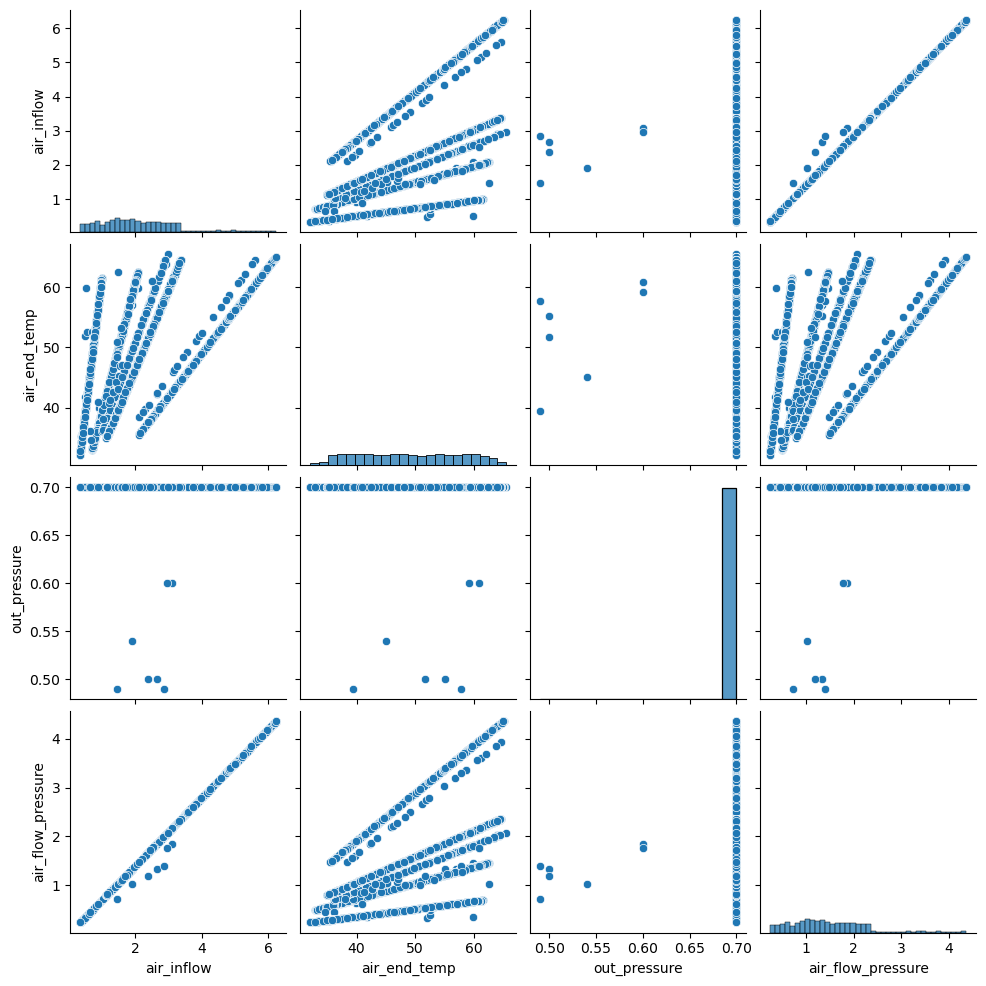

In [2]:
import seaborn as sns
sns.pairplot(test_data[['air_inflow', 'air_end_temp', 'out_pressure', 'air_flow_pressure']])
plt.show()

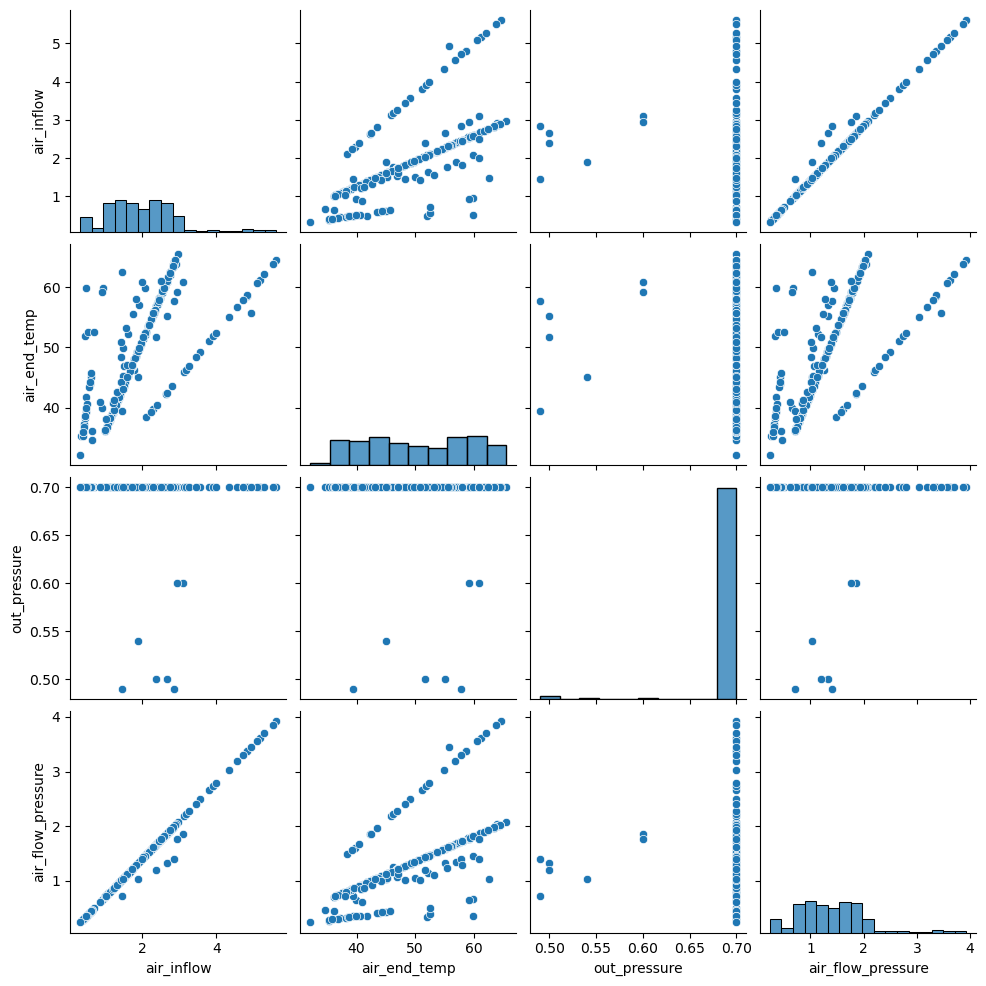

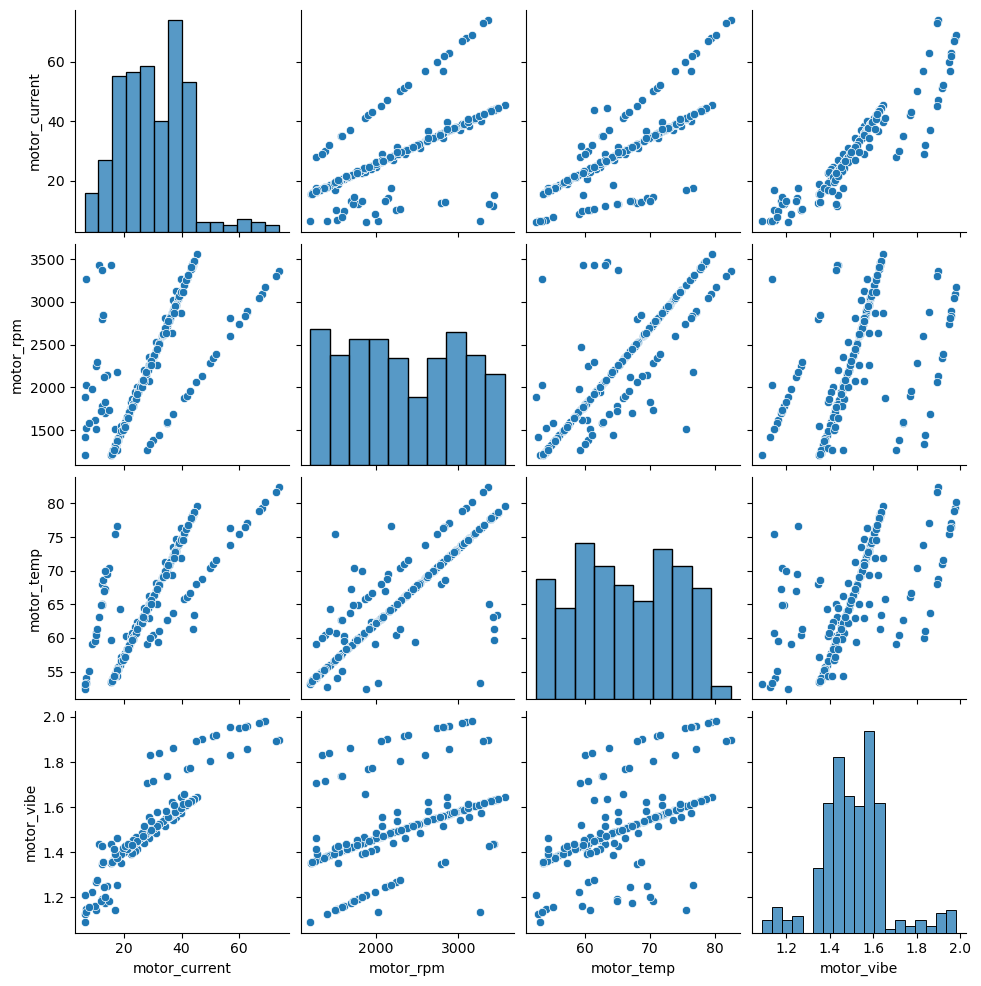

In [3]:
anomaly_plot(test_data, preds)

In [5]:
test_data['label'] = preds
test_data['treshold'] = threshold

In [6]:
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [10]:
yes.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,vibration_endtemp_product,rpm_airflow_product,compression_ratio,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,label,treshold
count,15.000000,15.000000,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000
mean,2.386000,51.597333,7.000000e-01,30.893333,2527.666667,68.085333,1.478027,7.0,1.670200,12.947766,...,77.205425,6584.455333,0.329654,0.000944,0.036747,0.007517,0.641600,130401.003769,0.0,0.999931
std,0.748282,9.906409,1.149190e-16,9.686044,792.453033,8.804113,0.102085,0.0,0.523797,0.016932,...,19.546459,3612.930556,0.128177,0.000001,0.002627,0.000232,0.045842,76939.909411,0.0,0.000092
min,1.220000,36.160000,7.000000e-01,15.800000,1293.000000,54.370000,1.313724,7.0,0.854000,12.913386,...,47.504248,1577.460000,0.208333,0.000942,0.033710,0.007225,0.588554,26838.586309,0.0,0.999618
25%,1.825000,44.175000,7.000000e-01,23.640000,1934.000000,61.490000,1.404701,7.0,1.277500,12.934909,...,62.083698,3546.425000,0.235300,0.000943,0.034715,0.007335,0.606140,64652.988305,0.0,0.999936
50%,2.430000,52.230000,7.000000e-01,31.510000,2578.000000,68.640000,1.488400,7.0,1.701000,12.950820,...,77.739110,6264.540000,0.288066,0.000944,0.036269,0.007496,0.633292,120906.835964,0.0,0.999961
75%,2.975000,59.375000,7.000000e-01,38.500000,3150.000000,75.000000,1.558142,7.0,2.082500,12.962937,...,92.515200,9371.535000,0.385370,0.000945,0.038481,0.007686,0.671961,188973.594150,0.0,0.999973
max,3.360000,64.450000,7.000000e-01,43.460000,3556.000000,79.510000,1.605430,7.0,2.352000,12.969697,...,103.469956,11948.160000,0.573770,0.000946,0.041143,0.007885,0.718220,248109.171777,0.0,0.999980


In [9]:
no.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,air_flow_pressure,current_by_airflow,...,vibration_endtemp_product,rpm_airflow_product,compression_ratio,airflow_per_rotation,efficiency,air_density,volumetric_efficiency,work_input,label,treshold
count,4.000000,4.000000,4.0,4.00000,4.00000,4.000000,4.000000,4.0,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000
mean,1.895000,49.400000,0.7,29.03000,2272.00000,65.247500,1.492951,7.0,1.326500,15.319246,...,74.309968,4614.590000,0.391599,0.000834,0.030677,0.007566,0.559960,108491.859082,1.0,0.372270
std,0.586373,8.785522,0.0,8.98232,702.97321,7.811241,0.084737,0.0,0.410461,0.026241,...,17.968257,3039.986762,0.096403,0.000001,0.001662,0.000201,0.030326,79154.355529,0.0,0.011892
min,1.480000,43.150000,0.7,22.64000,1772.00000,59.690000,1.430311,7.0,1.036000,15.297297,...,61.717930,2622.560000,0.253623,0.000832,0.028252,0.007270,0.515695,57381.341013,1.0,0.363467
25%,1.570000,44.567500,0.7,24.08750,1885.25000,60.950000,1.446288,7.0,1.099000,15.302773,...,64.464998,2963.240000,0.365130,0.000834,0.030360,0.007530,0.554195,65784.842594,1.0,0.366399
50%,1.670000,46.045000,0.7,25.60000,2003.50000,62.265000,1.462043,7.0,1.169000,15.311719,...,67.330249,3351.480000,0.419899,0.000835,0.031232,0.007641,0.570103,75151.836878,1.0,0.367897
75%,1.995000,50.877500,0.7,30.54250,2390.25000,66.562500,1.508706,7.0,1.396500,15.328193,...,77.175219,5002.830000,0.446368,0.000835,0.031550,0.007677,0.575868,117858.853367,1.0,0.373768
max,2.760000,62.360000,0.7,42.28000,3309.00000,76.770000,1.617406,7.0,1.932000,15.356250,...,100.861443,9132.840000,0.472973,0.000835,0.031993,0.007711,0.583939,226282.421559,1.0,0.389819


711
1107
1098
918
918
746
748
558


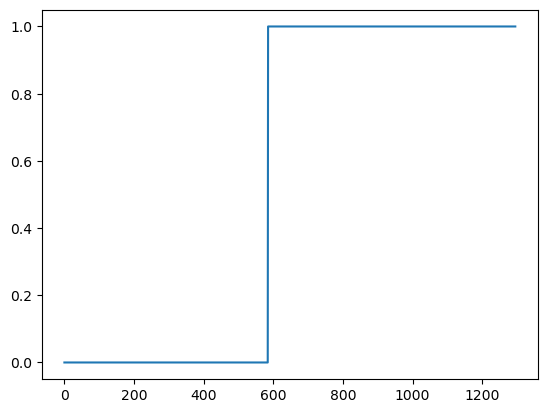

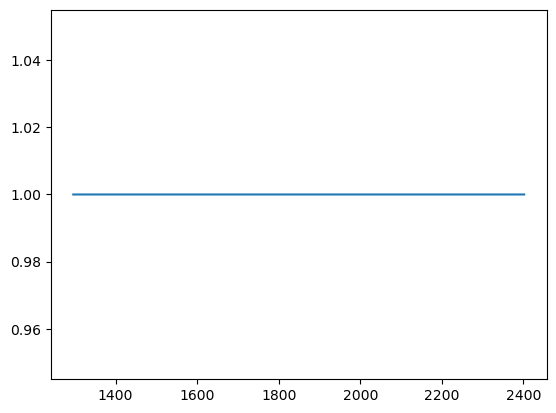

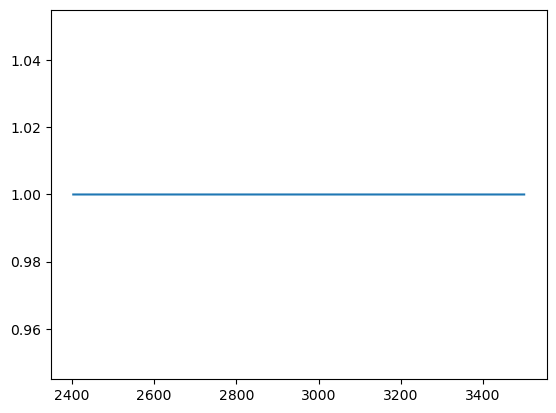

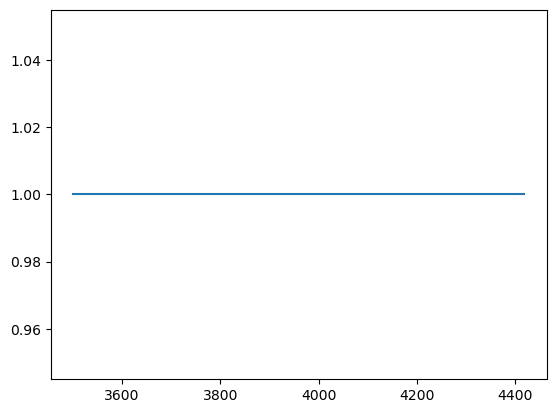

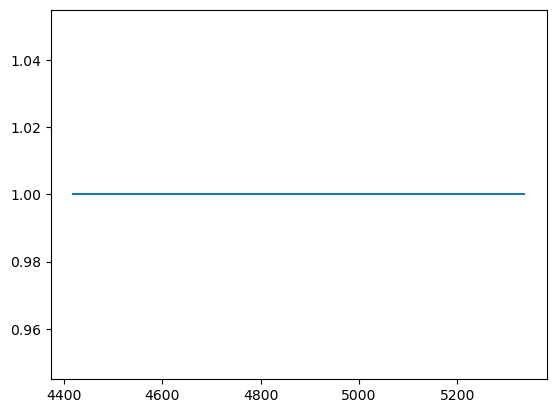

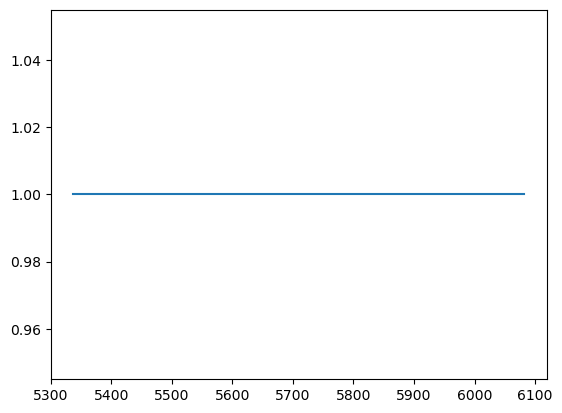

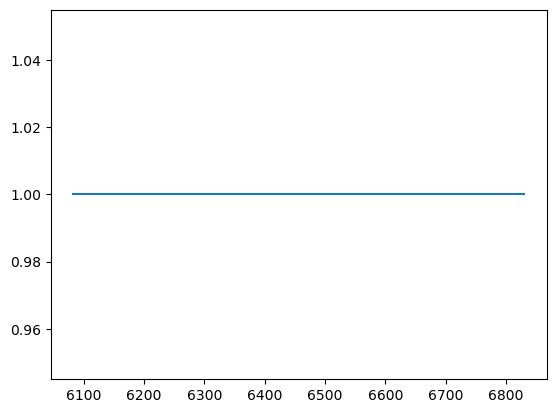

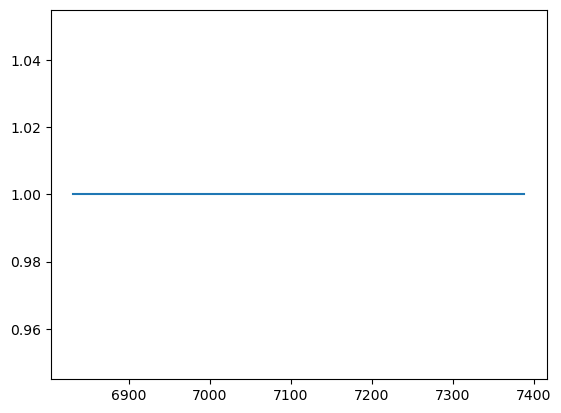

In [15]:
predictions = pd.read_csv(r"C:\Project_MB\Anomaly-Detection-of-Air-Compressor\data\submission\20230409_210715submission.csv")

predictions00 = predictions[:1296]
predictions01 = predictions[1296:2403]
predictions02 = predictions[2403:3501]
predictions03 = predictions[3501:4419]
predictions04 = predictions[4419:5337]
predictions05 = predictions[5337:6083]
predictions06 = predictions[6083:6831]
predictions07 = predictions[6831:]

print(len(predictions00[predictions00['label'] == 1]))
print(len(predictions01[predictions01['label'] == 1]))
print(len(predictions02[predictions02['label'] == 1]))
print(len(predictions03[predictions03['label'] == 1]))
print(len(predictions04[predictions04['label'] == 1]))
print(len(predictions05[predictions05['label'] == 1]))
print(len(predictions06[predictions06['label'] == 1]))
print(len(predictions07[predictions07['label'] == 1]))

predict_type = [predictions00, predictions01, predictions02, predictions03, predictions04, predictions05, predictions06, predictions07]

for type in predict_type:
    plt.plot(type['label'])
    plt.show()
    

In [21]:
train_data = pd.read_csv(r'data\raw\train_data.csv')
pca_train = pd.read_csv(r'data\processed\PCA_train_15_feature.csv')
train_data = build_features.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
pca_test = pd.read_csv(r'data\processed\PCA_test_15_feature.csv')
test_data = build_features.create_derived_features(test_data)


train_data.to_csv('train_ju.csv', index=False)
test_data.to_csv('test_ju.csv', index=False)